In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from io import BytesIO
from src import Encoder, Decoder
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns
sns.set_style('whitegrid')

from IPython.display import Audio

import logging
import structlog
structlog.configure(
    wrapper_class=structlog.make_filtering_bound_logger(logging.WARNING)
)

# Data encoding
Data is split into bits and then encoded into symbols using a modulation scheme.

## OFDM symbols
Encoded symbols are then combined using OFDM modulation to create a waveform.

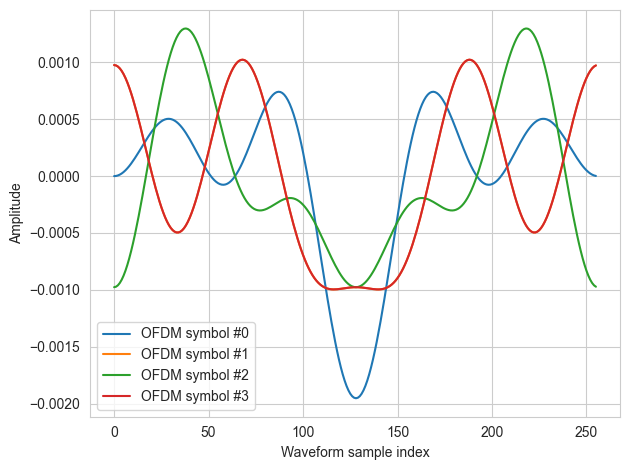

In [2]:
data_as_bytes = bytearray(b'Linear algebra is everywhere!')
encoder = Encoder(modulation='bpsk', n_subcarriers=4, carrier_frequency_hz=1024, ofdm_frequency_hz=64)
decoder = Decoder(modulation='bpsk', n_subcarriers=4, carrier_frequency_hz=1024, ofdm_frequency_hz=64)
data_as_bits = encoder.read_bytes(data_as_bytes)
data_as_psk_symbols = encoder.modulation.modulate(data_as_bits)
data_as_psk_symbols = data_as_psk_symbols.reshape(-1, encoder.modulation.n_subcarriers)
data_as_waveform = encoder._make_symbols(data_as_psk_symbols)

for i in range(4):
    plt.plot(np.real(data_as_waveform[i, :]), label=f'OFDM symbol #{i}')
plt.legend()
plt.xlabel('Waveform sample index')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.savefig('plots/ofdm_symbols.pdf')

## Modulation using a carrier frequency
OFDM frames are joined together and multiplied with a carrier frequency to create a modulated signal.

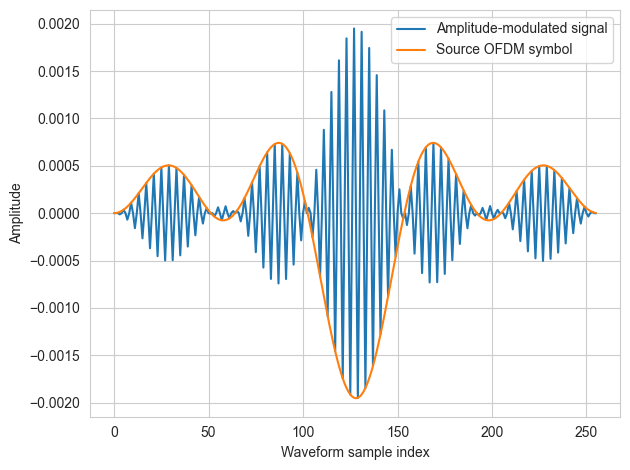

In [3]:
data_as_bytes = bytearray(b'Linear algebra is everywhere!')
signal = encoder.encode(data_as_bytes)

plt.plot(np.real(signal[:256]), label='Amplitude-modulated signal')
plt.plot(np.real(data_as_waveform[0, :256]), label='Source OFDM symbol')
plt.xlabel('Waveform sample index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.savefig('plots/carrier_modulation.pdf')

# Decoding
The amplitude-modulated signal is demodulated to extract the OFDM symbols.
## Amplitude demodulation
The amplitude-modulated signal is multiplied with the carrier signal to extract the OFDM symbols. Then FFT is applied to extract the subcarriers (the high-frequency parts are ignored).

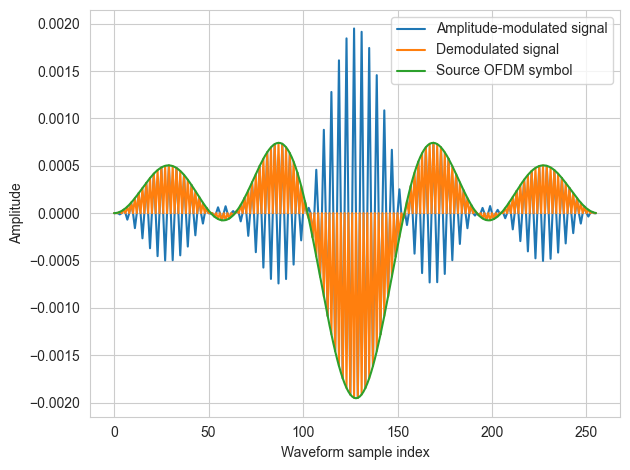

In [4]:
data_as_bytes = bytearray(b'Linear algebra is everywhere!')
signal = encoder.encode(data_as_bytes)
carrier_signal = encoder._make_carrier_waveform(signal)
demodulated_signal = signal * carrier_signal

plt.plot(np.real(signal[:256]), label='Amplitude-modulated signal')
plt.plot(np.real(demodulated_signal[:256]), label='Demodulated signal')
plt.plot(np.real(data_as_waveform[0, :256]), label='Source OFDM symbol')

plt.xlabel('Waveform sample index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.savefig('plots/carrier_demodulation.pdf')

## PSK demodulation
The demodulated signal is then demodulated to extract the bits.

In [5]:
fft_no_carrier = decoder._remove_carrier(signal.reshape(-1, 256))
psk_symbols = decoder._get_ofdm_subcarriers(fft_no_carrier)
demodulated_bits = decoder.modulation.demodulate(psk_symbols.flatten())

recovered_message = bytearray(np.packbits(demodulated_bits, bitorder='big'))
recovered_message = recovered_message.decode()

print(f'Recovered message: "{recovered_message}"')

Recovered message: "Linear algebra is everywhere!"


# Complete flow using an image

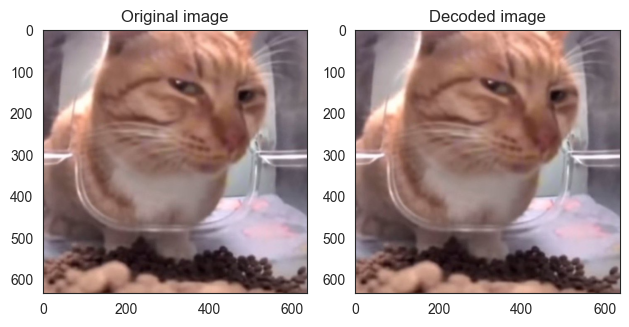

In [6]:
sns.set_style('white')
image = Image.open('tests/mr_fresh.jpg')

image_bytes = open('tests/mr_fresh.jpg', 'rb').read()
encoder = Encoder(modulation='qpsk', n_subcarriers=128, carrier_frequency_hz=4000, ofdm_frequency_hz=1024)
decoder = Decoder(modulation='qpsk', n_subcarriers=128, carrier_frequency_hz=4000, ofdm_frequency_hz=1024)

signal = encoder.encode(image_bytes)
decoded_image_bytes = decoder.decode(signal)
decoded_image = Image.open(BytesIO(decoded_image_bytes))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original image')

plt.subplot(1, 2, 2)
plt.imshow(decoded_image)
plt.title('Decoded image')
plt.tight_layout()

Audio(signal, rate=encoder.sample_rate)

# Performance estimation

In [18]:
test_parameters = [
    {
        'modulation': 'qpsk',
        'n_subcarriers': 128,
        'carrier_frequency_hz': 4000,
        'ofdm_frequency_hz': 1024
    },
    {
        'modulation': 'bpsk',
        'n_subcarriers': 128,
        'carrier_frequency_hz': 4000,
        'ofdm_frequency_hz': 1024
    },
    {
        'modulation': 'qpsk',
        'n_subcarriers': 64,
        'carrier_frequency_hz': 4000,
        'ofdm_frequency_hz': 1024
    },
    {
        'modulation': 'qpsk',
        'n_subcarriers': 128,
        'carrier_frequency_hz': 4000,
        'ofdm_frequency_hz': 512
    },
    {
        'modulation': 'bpsk',
        'n_subcarriers': 128,
        'carrier_frequency_hz': 4000,
        'ofdm_frequency_hz': 512
    },
    {
        'modulation': 'qpsk',
        'n_subcarriers': 128,
        'carrier_frequency_hz': 4000,
        'ofdm_frequency_hz': 2048
    },
    {
        'modulation': 'bpsk',
        'n_subcarriers': 128,
        'carrier_frequency_hz': 4000,
        'ofdm_frequency_hz': 2048
    },
]

results = []

for params in test_parameters:
    encoder = Encoder(**params)
    decoder = Decoder(**params)

    label = f"{params['modulation']}_nsub{params['n_subcarriers']}_Fc{params['carrier_frequency_hz']}Hz_ODFM{params['ofdm_frequency_hz']}Hz"
    print(f"Testing {label}")

    signal = encoder.encode(image_bytes)
    decoded_image_bytes = decoder.decode(signal)

    original_size = len(image_bytes)
    duration = len(signal) / encoder.sample_rate

    results.append({
        'label': label,
        'speed_kbps': 8 * original_size / duration / 1024,
        **params
    })

Testing qpsk_nsub128_Fc4000Hz_ODFM1024Hz
Testing bpsk_nsub128_Fc4000Hz_ODFM1024Hz
Testing qpsk_nsub64_Fc4000Hz_ODFM1024Hz
Testing qpsk_nsub128_Fc4000Hz_ODFM512Hz
Testing bpsk_nsub128_Fc4000Hz_ODFM512Hz
Testing qpsk_nsub128_Fc4000Hz_ODFM2048Hz
Testing bpsk_nsub128_Fc4000Hz_ODFM2048Hz


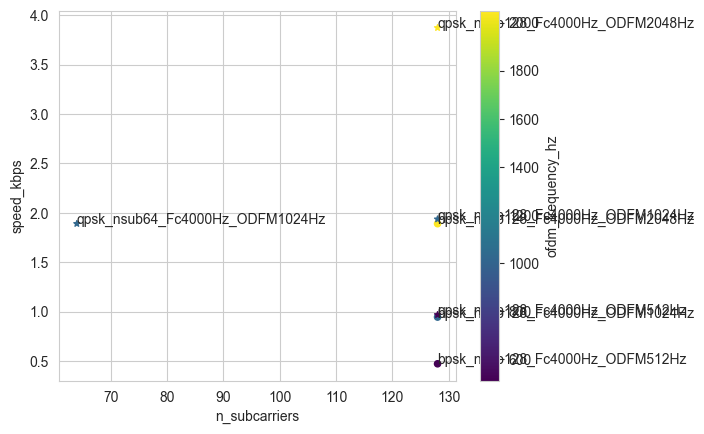

In [24]:
import pandas as pd
df = pd.DataFrame(results)
df['is_bpsk'] = df['modulation'] == 'bpsk'
df['is_qpsk'] = df['modulation'] == 'qpsk'

# sns.set_style('whitegrid')
# plt.figure()
# df[df['is_bpsk']].plot(y='speed_kbps', x='n_subcarriers', c='ofdm_frequency_hz', kind='scatter', cmap='viridis', marker='o', ax=plt.gca())
# df[df['is_qpsk']].plot(y='speed_kbps', x='n_subcarriers', c='ofdm_frequency_hz', kind='scatter', cmap='viridis', marker='*', ax=plt.gca(), colorbar=False)
# for i, row in df.iterrows():
#     plt.text(row['n_subcarriers'], row['speed_kbps'], row['label'])


In [31]:
df['speed_kbps'] = df['speed_kbps'].round(2)
df.drop(['label', 'is_bpsk', 'is_qpsk'], axis=1)

speed_kbps modulation  n_subcarriers  carrier_frequency_hz  \
0        1.94       qpsk            128                  4000   
1        0.95       bpsk            128                  4000   
2        1.89       qpsk             64                  4000   
3        0.97       qpsk            128                  4000   
4        0.47       bpsk            128                  4000   
5        3.87       qpsk            128                  4000   
6        1.89       bpsk            128                  4000   

   ofdm_frequency_hz  
0               1024  
1               1024  
2               1024  
3                512  
4                512  
5               2048  
6               2048